In [1]:
import pygame
import numpy as np
from scipy import linalg
from sklearn.neural_network import MLPRegressor
import pandas as pd
import pickle

pygame 2.1.2 (SDL 2.0.18, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [14]:
import matplotlib.pyplot as plt

In [14]:
class InvertedPendulum():
    # Initialize environment.
    def __init__(self, xRef = 0.0, randomParameters = False, randomSensor = False, randomActuator = False):
        # System parameters.
        self.tau = 0.01
        if not randomParameters:
            self.g = 9.8
            self.M = 1.0
            self.m = 0.1
            self.l = 0.5
        else:
            self.g = 9.8 + 0.098*np.random.randn()
            self.M = 1.0 + 0.1 *np.random.randn()
            self.m = 0.1 + 0.01*np.random.randn()
            self.l = 0.5 + 0.05*np.random.randn()
            
        self.xRef = xRef

        # Drawing parameters.
        self.cartWidth = 80
        self.cartHeight = 40
        self.pendulumLength = 200
        self.baseLine = 350
        self.screenWidth = 800
        self.screenHeight = 400
        
        # Variable to see if simulation ended.
        self.finish = False
        
        # Variable to see if there is randomness in the sensors and actuators.
        self.randomSensor   = randomSensor
        self.randomActuator = randomActuator
        
        # Create a random observation.
        self.reset()

        # Create screen.
        self.screen = pygame.display.set_mode((self.screenWidth, self.screenHeight))
        pygame.display.set_caption('Inverted Pendulum')
        self.screen.fill('White')
        
        # Create a clock object.
        self.clock = pygame.time.Clock()
        pygame.display.update()

    # Close environment window.
    def close(self):
        pygame.quit()
        
    # Reset system with a new random initial position.
    def reset(self):
        self.observation = np.random.uniform(low = -0.05, high = 0.05, size = (4,))
        if self.randomSensor:
            return self.noise_sensors(self.observation.copy())
        else:
            return self.observation.copy()
    
    # Insert noise on the sensors.
    def noise_sensors(self, observation, noiseVar = 0.01):
        observation[0] = observation[0] + noiseVar*np.random.randn()
        observation[1] = observation[1] + noiseVar*np.random.randn()
        observation[2] = observation[2] + noiseVar*np.random.randn()
        observation[3] = observation[3] + noiseVar*np.random.randn()
        return observation
    
    # Insert noise on actuator.
    def noise_actuator(self, action, noiseVar = 0.01):
        action += noiseVar * np.random.randn()
        return action
    
    # Display object.
    def render(self):
        # Check for all possible types of player input.
        for event in pygame.event.get():
            # Command for closing the window.
            if (event.type == pygame.QUIT):
                pygame.quit()
                self.finish = True
                return None
            
            if (event.type == pygame.KEYDOWN):
                if (event.key == pygame.K_LEFT):
                    self.xRef -= 0.01
                    
                elif (event.key == pygame.K_RIGHT):
                    self.xRef += 0.01
                    
                elif (event.key == pygame.K_SPACE):
                    self.step(200*np.random.randn())
        
        # Apply surface over display.
        self.screen.fill('White')
        pygame.draw.line(self.screen, 'Black', (0, self.baseLine), (self.screenWidth, self.baseLine))
        
        # Get position for cart.
        xCenter = self.screenHeight + self.screenHeight * self.observation[0]
        xLeft   = xCenter - self.cartWidth//2
        # xRight  = xCenter + self.cartWidth//2
        
        # Get position for pendulum.
        pendX = xCenter +  self.pendulumLength * np.sin(self.observation[2])
        pendY = self.baseLine - self.pendulumLength * np.cos(self.observation[2])
        
        # Display objects.
        pygame.draw.line(self.screen,   'Green', (int(self.screenHeight + self.xRef * self.screenHeight), 0), (int(self.screenHeight + self.xRef * self.screenHeight), self.baseLine), width = 1)
        pygame.draw.rect(self.screen,   'Black', (xLeft, self.baseLine-self.cartHeight//2, self.cartWidth, self.cartHeight),  width = 0)
        pygame.draw.line(self.screen,   (100, 10, 10),   (xCenter, self.baseLine), (pendX, pendY), width = 6)
        pygame.draw.circle(self.screen, 'Blue',  (xCenter, self.baseLine), 10)
    
        # Draw all our elements and update everything.
        pygame.display.update()
        
        # Limit framerate.
        self.clock.tick(60)

    # Perform a step.
    def step(self, force):
        if self.randomActuator:
            force = self.noise_actuator(force)
        x1 = self.observation[0]
        x2 = self.observation[1]
        x3 = self.observation[2]
        x4 = self.observation[3]
        x4dot = (self.g * np.sin(x3) - np.cos(x3) * (force + self.m * self.l * x4**2 * np.sin(x3))/(self.M + self.m)) / (self.l * (4.0/3.0 - self.m * np.cos(x3)**2 / (self.M + self.m)))
        x2dot = (force + self.m * self.l * x4**2 * np.sin(x3))/(self.M + self.m) - self.m * self.l * x4dot * np.cos(x3) / (self.M + self.m)
        self.observation[0] = x1 + self.tau * x2
        self.observation[1] = x2 + self.tau * x2dot
        self.observation[2] = x3 + self.tau * x4
        self.observation[3] = x4 + self.tau * x4dot
        if self.randomSensor:
            return self.noise_sensors(self.observation.copy())
        else:
            return self.observation.copy()

In [4]:
Dados = pd.read_csv(r'C:\Users\Mateus\Desktop\Trabalho 3\PenduloInvertidoFuzzyArtigo.csv', on_bad_lines='skip', header=None)
# Dados.values
Dados.head(5)
# print(Dados)

,0,1,2,3,4
0,-0.514756,-5.057626,0.013547,7.678928,-522.084200
1,-0.565332,0.143587,0.090337,-0.120185,533.101514
2,-0.563896,0.880795,0.089135,-1.208226,75.674807
3,-0.555088,0.331017,0.077053,-0.373748,-56.326216
4,-0.551778,0.115740,0.073315,-0.040475,-22.019596


In [5]:
Dados.shape

(13159, 5)

In [6]:
Entradas = Dados.iloc[:,:-1].values
Saidas = Dados.iloc[:,4:].values
# Entradas.head()
# Saidas.head()

In [19]:
Saidas

array([[-5.22084200e+02],
       [ 5.33101514e+02],
       [ 7.56748074e+01],
       ...,
       [-1.92472764e-03],
       [-1.94693534e-03],
       [-1.96813880e-03]])

In [ ]:
Modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
Modelo = MLPRegressor(hidden_layer_sizes=[64,32,8,4,2,1], activation='relu', solver='adam', max_iter=1000000)

In [10]:
Modelo.fit(Entradas, Saidas)

c:\Users\Mateus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MLPRegressor(hidden_layer_sizes=[64, 32, 8, 4, 2, 1], max_iter=1000000)

In [11]:
Ypred=Modelo.predict(Entradas)

In [18]:
Ypred

array([ -3.88720444, 127.38668923, 166.13615383, ...,  -3.88720444,
        -3.88720444,  -3.88720444])

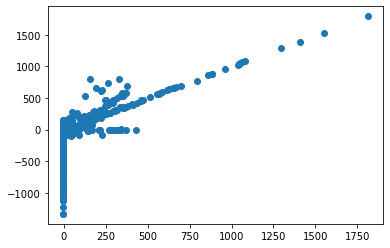

In [16]:
plt.scatter(Ypred,Saidas)

In [17]:
Ypred-Saidas

array([[ 518.19699512,  649.47088879,  688.22035339, ...,  518.19699512,
         518.19699512,  518.19699512],
       [-536.98871848, -405.71482481, -366.96536021, ..., -536.98871848,
        -536.98871848, -536.98871848],
       [ -79.56201186,   51.7118818 ,   90.46134641, ...,  -79.56201186,
         -79.56201186,  -79.56201186],
       ...,
       [  -3.88527971,  127.38861395,  166.13807856, ...,   -3.88527971,
          -3.88527971,   -3.88527971],
       [  -3.8852575 ,  127.38863616,  166.13810077, ...,   -3.8852575 ,
          -3.8852575 ,   -3.8852575 ],
       [  -3.8852363 ,  127.38865737,  166.13812197, ...,   -3.8852363 ,
          -3.8852363 ,   -3.8852363 ]])

In [12]:
# Modelo.save('G:\Outros computadores\Meu modelo Computador\IFES\9 Período\Controle Inteligente\Trabalho 3\ RedeTreinada.h5')

filename = '64Neuronios.sav'
pickle.dump(Modelo, open(filename, 'wb'))

In [15]:
g = 9.8
M = 1.0
m = 0.1
l = 0.5
L = 2*l
I = m*L**2 / 12

# SENSORES.
# sensores[0]: posição.
# sensores[1]: velocidade.
# sensores[2]: ângulo.
# sensores[3]: velocidade angular.
# SETPOINT em env.xRef.


# Função de controle: Ação nula.
def funcao_controle_1(sensores):
    # Model = MLPClassifier(hidden_layer_sizes=[4], activation='relu', learning_rate=0.01, max_iter=80000)
    # Model.fit(sensores)
    # acao = Model.predict(sensores)

    loaded_model = pickle.load(open(filename, 'rb'))
    result = loaded_model.score(sensores[0], sensores[1], sensores[2], sensores[3])
    acao = result
    return acao


# Cria o ambiente de simulação.
env = InvertedPendulum(0.50)

# Reseta o ambiente de simulação.
sensores = env.reset()

while True:
    # Renderiza o simulador.
    env.render()
    if env.finish:
        break
    
    # Calcula a ação de controle.
    acao = funcao_controle_1(sensores)  # É ESSA A FUNÇÃO QUE VOCÊS DEVEM PROJETAR.
    
    # Aplica a ação de controle.
    sensores = env.step(acao)
    
env.close()

TypeError: RegressorMixin.score() takes from 3 to 4 positional arguments but 5 were given

: 